## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [187]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [188]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [189]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [190]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [191]:
df.query('converted == 1')['user_id'].nunique()/ df.shape[0]   # count : 35237, nunique() : 35173

0.1194418598333322

e. The number of times the `new_page` and `treatment` don't line up.

In [192]:
df.groupby(['landing_page', 'group']).count()

user_id  timestamp  converted
landing_page group                                   
new_page     control       1928       1928       1928
             treatment   145311     145311     145311
old_page     control     145274     145274     145274
             treatment     1965       1965       1965

In [193]:
df.groupby(['group', 'landing_page']).user_id.count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: user_id, dtype: int64

f. Do any of the rows have missing values?

In [194]:
df.info()
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


0

In [195]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [196]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

In [197]:
# If it uses drop_duplicates(['group','landing_page']), it becomes to be remove the duplicated user_id.
# So, to check the information of the duplicated user_id, drop the duplicated group&page with INDEX!!

#df2 = df.drop_duplicates(['group','landing_page'])

In [198]:
drop_index = df[((df['group'] == 'treatment') & (df['landing_page'] == 'old_page'))
  | ((df['group'] == 'control') & (df['landing_page'] == 'new_page'))].index


In [199]:
df2 = df.drop(drop_index)

In [200]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [201]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [202]:
df2.duplicated('user_id').sum()

1

c. What is the row information for the repeat **user_id**? 

In [203]:
df2[df2.duplicated('user_id')]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [204]:
df2 = df2.drop(index = 2893)

In [205]:
df2.user_id.nunique()

290584

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [206]:
df2.head()
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [207]:
df2[df2['converted'] == 1].user_id.count() / df2.shape[0]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [218]:
control_converted = df2.query("group == 'control' and converted == 1").user_id.count()/  df2.query('group == "control"').user_id.count()
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [219]:
treat_converted = df2.query("group == 'treatment' and converted == 1").user_id.count()/  df2.query('group == "treatment"').user_id.count()
treat_converted

0.11880806551510564

In [220]:
obs_diff = treat_converted - control_converted
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [211]:
df2.query('landing_page == "new_page"')['user_id'].count() / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

In [212]:
df2.timestamp.min(), df2.timestamp.max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

**<font color = red>Your answer goes here.</font>**
##### In the control group, the proportion they converted is 0.12 and in the treatement group, the proportion they converted is 0.118. With these proportions, the control group's converted rate is greater than the treatment group's. So there is no sufficient evidence to say that the treatment page leads to more conversion than the control page considering these proportions. 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here.**

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$

Null hypothesis is the converted rates for the old pages are greater and equal to those for the new pages.<br>
Alternative hypothesis is the converted rates for the new pages are greater than those for the old pages. <br>
Significance level(α) : 0.05

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>
$$H_0: p_{new} - p_{old} = 0$$

$$H_1: p_{new} - p_{old} \neq 0$$

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [175]:
df2.shape

(290584, 5)

a. What is the **convert rate** for $p_{new}$ under the null? 

In [176]:
#get p under the null - In Ho, P_old = P_new
p_new = df['converted'].mean()
p_new

0.11965919355605512

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [177]:
#get p under the null
p_old = df['converted'].mean()
p_old

0.11965919355605512

c. What is $n_{new}$?

In [178]:
new_convert_size = (df2.query('landing_page == "new_page"')['converted'] == 1).count()
new_convert_size

145310

d. What is $n_{old}$?

In [179]:
old_convert_size = (df2.query('landing_page == "old_page"')['converted'] == 1).count()
old_convert_size

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.
##### Reference : https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html?highlight=choice#numpy.random.choice

In [180]:
# simulate 'converted' with random under the null 

new_page_converted = np.random.choice([0,1], p=(p_new, 1-p_new), size = new_convert_size)
new_page_converted.mean()

0.8805656871516069

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [181]:
old_page_converted = np.random.choice([0,1], p=(p_old, 1-p_old), size = new_convert_size)
old_page_converted.mean()

0.8824444291514693

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [182]:
new_page_converted.mean() - old_page_converted.mean()

-0.0018787419998623767

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [183]:
# The difference of 'newpage converted proportion' and 'oldpage converted proportion'
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], p=(p_new, 1-p_new), size = new_convert_size)
    old_page_converted = np.random.choice([0,1], p=(p_old, 1-p_old), size = new_convert_size)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())


In [184]:
p_diffs = np.array(p_diffs)
p_diffs

array([ 8.87757209e-04,  1.07356686e-03, -5.98719978e-04, ...,
       -1.88562384e-03, -9.15284564e-04,  6.88183883e-06])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

#### As we can see before, I assumed Ho is true.  That means P𝑛𝑒𝑤 is equal to P𝑜𝑙𝑑.

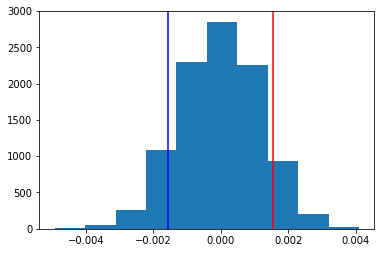

In [225]:
#sampling distribution under the null
p_diffs = np.array(p_diffs)

plt.hist(p_diffs)
null_mean = p_diffs.mean()
low_value = obs_diff
high_value = null_mean + (null_mean - obs_diff)
plt.axvline(x = high_value, color = 'r');
plt.axvline(x = low_value, color = 'b');

In [231]:
(p_diffs < low_value).mean() + (p_diffs > high_value).mean()

0.1896

<font color = blue > Based on the Alternative Hypothesis(𝐻1:P𝑛𝑒𝑤−P𝑜𝑙𝑑≠0), I will find the P-value in the both extreme areas of the distribution.
Because P-value is greater than significance level(α) : 0.19 > 0.05, we don't reject the null Hypothesis. That means P𝑛𝑒𝑤 is equal to P𝑜𝑙𝑑. </font>

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [217]:
(p_diffs > obs_diff).mean()

0.9038

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**<font color = red >Put your answer here.</font>** <br>
At first, our hypothesis is that you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. <br> Based on the alternative hypothesis(𝐻1:P𝑛𝑒𝑤−P𝑜𝑙𝑑>0), I can find P-value, P-value is 0.0904 (in part j). <br> The P-value is greater than significance level(α) : 0.0904 > 0.05. So, we don't reject the null hypothesis(𝐻0:P𝑛𝑒𝑤−P𝑜𝑙𝑑≤0). With a P-value, the difference between the new and old pages does not appear to be significant. It looks like the company doesn't need to implement the newpage of website.
<br><br>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [227]:
import statsmodels.api as sm

convert_old = (df2.query('landing_page == "old_page" and converted == 1'))['user_id'].count()
convert_new = (df2.query('landing_page == "new_page"and converted == 1')['user_id']).count()
n_old = df2[df2['landing_page'] == 'old_page'].user_id.count()
n_new = df2[df2['landing_page'] == 'new_page'].user_id.count()
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [230]:
cons = np.array([convert_old, convert_new])
obs = np.array([n_old, n_new])
sm.stats.proportions_ztest(cons, obs, alternative = "smaller")

(1.3109241984234394, 0.9050583127590245)

In [241]:
# create normal distribution and find the significance level 0.05
import scipy.stats as st
st.t.interval(0.95, len(df2['converted'])-1, loc=np.mean(df2['converted']), scale=st.sem(df2['converted']))

(0.11841726702450327, 0.12077690746548929)

##### Reference : https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
##### https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.t.html

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**<font color = red>Put your answer here.</font>**
<br> <b>statsmodels.stats.proportion.proportions_ztest</b> is to test for proportions based on normal (z) test. And return values are zstat and p-value.
<br> In the function, proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False),
<br> 1. count is the number of successes for each independent sample. So count in my data means the number of users converted with old and new page. That is  np.array([convert_old, convert_new])
<br> 2. nobs is the number of trials or observations. So in my data, each number of users of old and new page. That is np.array([n_old, n_new])
<br> 3. alternative include string in [‘two-sided’, ‘smaller’, ‘larger’]
<br> P-value through ztest is 0.905 and our calculated P-value is 0.0904. They are approximately the same values. Also, significance level is 0.05, 
##### Reference : https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html?highlight=proportions_ztest

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**<font color = red> Put your answer here.</font>**
<br><b>Logistic Regression</b>. Because response variable have a conversion or no conversion, I should be prforming the logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [655]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [656]:
import statsmodels.api as sm

df2['intercept'] = 1 
df2['ab_page'] = pd.get_dummies(df22['group'])['treatment']
df2.head()

logis_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
result = logis_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        01:23:42   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

<b>Summary results</b>
#### Total count is 290584 and those coefficients have no means in Rogistic Regression. So I need to exponentiate the coefficients. Exponentiating the ab_page's coefficient is less than 1, so I try to have a reciprocal of this. Reciprocal means that this changes the direction for the unit increase, to a unit decrease.
#### Holding all other variables constant, the probability of an individual receives the treatment is 0.98 times. In other words, whenever an individual receives the page, the probability of an individual receives the treatment decrease 1.02 times.

In [658]:
np.exp(-0.0150), 1/np.exp(-0.0150)

(0.9851119396030626, 1.015113064615719)

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**<font color = red>Put your answer here.</font>**
<br> The p-value associated with ab_page is 0.19. In Part II, our p-value is 0.0907. The reason the former differs from the latter is as follows. The former is the value regardless of the group(control, treatment) and the latter is the value calculated by the difference of each two groups's converted rate. 
<br> As the result above (d), the probability of an individual receives the treatment is 0.98 times. It means the proability of an individual receives the control is higher than that of the treatment. So my regression model is associated with the null hypothesis.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**<font color = red>Put your answer here.</font>**
<br> I think I can divide our time(above 'timestamp' column) into morning and afternoon, and I can analyze whether the conversion rate is higher in the morning or afternoon. Because there isn't the only conversion based on which page a customer receives(the only predict variable) In reality, I think it needs to consider the time whether or not an individual converts. 
<br>
I think one disadvantage to adding additional terms into your regression model as follows. In analyzing the data with regression model, our result is estimated with the proaability. The probability is based on only the statistic description and the data. 
Actually, there are serveral factors caused conversions in reality I think. There seems to be a limit to analyzing variables by relying exclusively on data. 

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [672]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [673]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [674]:
### Create the necessary dummy variables
df_new['country'].unique()     #array(['UK', 'US', 'CA']
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop('US', axis = 1)    
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [675]:
### Fit Your Linear Model And Obtain the Results
# baseline => US
contury_logis_model = sm.Logit(df_new['converted'], df_new[['intercept','CA','UK','ab_page']])
results = contury_logis_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Jun 2019   Pseudo R-squ.:               2.323e-05
Time:                        03:00:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

<b>Summary Results</b>
<br>I need to exponentiate the coefficients in Rogistic Regression. Also, I try to have a reciprocal of coefficients(CA, ab_page) less than 1.( Reciprocal means that this changes the direction for the unit increase, to a unit decrease.)
<br>Holding all other variables constant, the probability of conversion in UK is 1.01 times higher than in the US, and he probability of conversion in CA is 0.96 times lower than in the US. So the country have an impact on conversion. 
<br> In interation between page and country, we can see the result on average in three country. Whenever an individual receives the page, the probability of an individual receives the new page decrease 0.37 times.

In [678]:
np.exp(results.params), 1/np.exp(0.960062),  1/np.exp(0.985168)

(intercept    0.136795
 CA           0.960062
 UK           1.009932
 ab_page      0.985168
 dtype: float64, 0.3828691473520865, 0.3733764944162148)

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.